# Interactive data visualization with Python

This tutorial builds upon previous posts on data analysis and mapping by demonstrating how to do simple interactice charts in Python. For this example we will use NYC's [tree census dataset](https://data.cityofnewyork.us/widgets/uvpi-gqnh), using the SODA API to access. Plotting will be done with Plotly, an open source visualization tool for Python.

Let's start by importing all the necessary libraries:

In [14]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import warnings
warnings.filterwarnings("ignore")

<br>
<br>

Next we can use the Socrata Python tool to download the city tree data. Below we specify the soda developer token and the location of the data. And by default Socrata limits the amount of data that can be downloaded to 20k rows, we uppdate that limit to 600k, as thats approximately how many rows are in the tree census.

In [3]:
client = Socrata("data.cityofnewyork.us", os.environ['nyc_soda_cuny_token'])

In [4]:
results = client.get("uvpi-gqnh", limit=600000)

In [5]:
trees = pd.DataFrame.from_records(results)

In [6]:
print(trees.shape)
trees.head()

(600000, 45)


,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.72309177,-73.84421522,1027431.148,202756.7687,29,739,4052307,4022210001
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.79411067,-73.81867946,1034455.701,228644.8374,19,973,4101931,4044750045
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.71758074,-73.9366077,1001822.831,200716.8913,34,449,3338310,3028870001
3,204337,217969,2015-09-05T00:00:00.000,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.71353749,-73.93445616,1002420.358,199244.2531,34,449,3338342,3029250001
4,189565,223043,2015-08-30T00:00:00.000,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.66677776,-73.97597938,990913.775,182202.426,39,165,3025654,3010850052


<br>
<br>

Usually all columns in datasets downloaded from Socrata is of a string / object type. Below we specify the numeric columns as either integers or floats respectively.

In [7]:
cols_int = ['tree_dbh', 'stump_diam']
cols_float = ['latitude', 'longitude',
              'x_sp', 'y_sp']
for column in cols_int:
    trees[column] = trees[column].astype(int)
for column in cols_float:
    trees[column] = trees[column].astype(float)

<br>
<br>

### Simple Bar Chart

The first data point we'll visualize is the amount of trees in each of the five boroughs in NYC. There are many ways to do this with Pandas – below we use the **value_counts()** method on a Series object. This method counts the occurences elements in a DataFrame, and returns a new Series object where the element names are the index and the values are the amount.

In [8]:
trees['boroname'].value_counts()

Queens           224748
Brooklyn         150555
Staten Island     97500
Bronx             78593
Manhattan         48604
Name: boroname, dtype: int64

<br>
<br>

Now that we have the number of trees in each borough, we need the information in a format that is understood by Plotly. Below we turn the resulting Series object above back into a DataFrame using the **reset_index()** method.

In [9]:
boro_data = trees['boroname'].value_counts().reset_index()
boro_data

,index,boroname
0,Queens,224748
1,Brooklyn,150555
2,Staten Island,97500
3,Bronx,78593
4,Manhattan,48604


<br>

Notice the column names in the above DataFrame are nonsensical – the boroname column is the amount of trees and the actual names of the boros are in a column called index. We can change that by using **rename()** and passing a dictionary to change these around.

In [10]:
boro_data = boro_data.rename(columns={'index':'boro', 
                                      'boroname': 'count'})
boro_data

,boro,count
0,Queens,224748
1,Brooklyn,150555
2,Staten Island,97500
3,Bronx,78593
4,Manhattan,48604


<br>
<br>

Now we are ready to pass the data to Plotly for visualizing.

Below are two of the main drivers behind nearly all Plotly visuals – a **Figure** object and a graph type, in this case **Bar**. We place the Bar object inside the figure and specify the X and Y columns by passing the columns of our DataFrame above.

Plotly by default always shows a control bar at the top each plot – below we turn this off by passing a dictionary to the *config* argument.

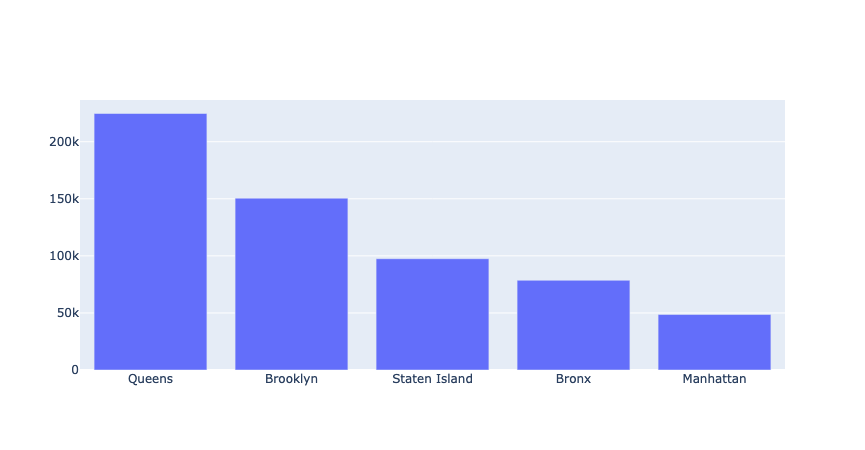

In [27]:
fig = go.Figure(
    go.Bar(
        x=boro_data['boro'], y=boro_data['count'])
)

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

<br>
<br>

The resulting graph above is raw and begs for a little customization. Customizing graphs is easy with Plotly with a **Layout** object. Below we specify a new background color (in RGB), a title, and set the width of the plot by giving the left + right margins. We also change the color of the bars themselves in the Bar object.

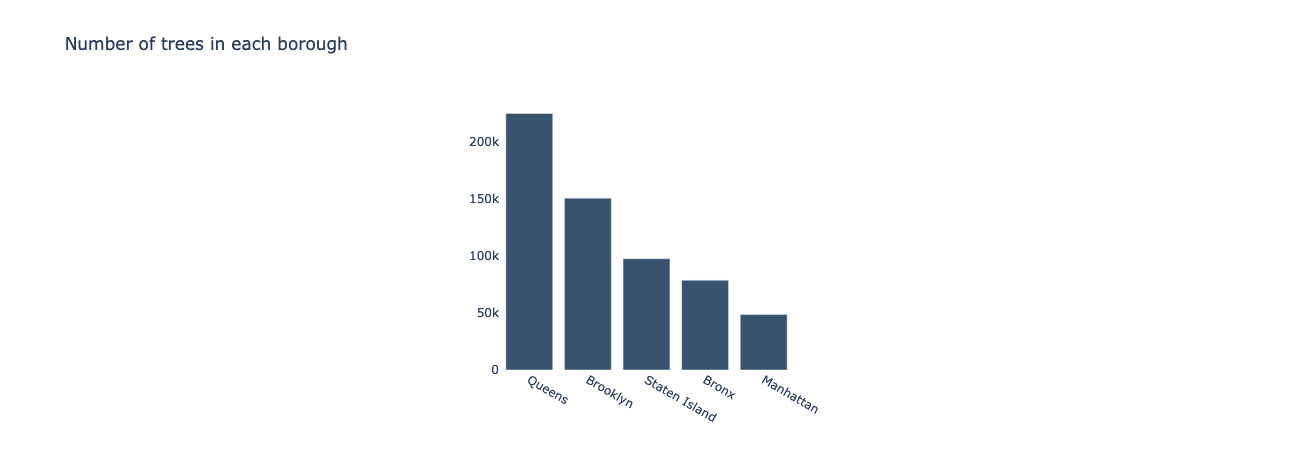

In [112]:
layout = go.Layout(
    plot_bgcolor='rgba(255,255,255,1)',
    title='Number of trees in each borough',
    margin=dict(l=500, r=500)
)

fig = go.Figure(
    go.Bar(
        x=boro_data['boro'], y=boro_data['count'],
    marker_color='rgb(55, 83, 109)'), 
    layout=layout
)

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

<br>
<br>

### Stacked Bar Charts

Next we'll use the **groupby()** method in Pandas to count the number of healthy trees in each borough. Groupby is one of the most powerful concepts within Pandas, allowing researchers to group DataFrame according to a specific (or multiple) entities, in this case Boroughs, and then aggregate values within groups. For example, below we group our DataFrame by boroname and (tree) health, and then count the occurences of good, fair, and poor trees within each boro.

In [37]:
trees.groupby(['boroname', 'health']).agg({'tree_id':'count'})

tree_id
boroname      health         
Bronx         Fair       9587
              Good      61985
              Poor       2774
Brooklyn      Fair      20298
              Good     118480
              Poor       5307
Manhattan     Fair       8801
              Good      34684
              Poor       2831
Queens        Fair      29324
              Good     176324
              Poor       7957
Staten Island Fair      13215
              Good      76799
              Poor       3908

<br>
<br>

As we did previously, below we convert the above group by result into a dataframe and change the column names.

In [41]:
boro_health = trees.groupby(['boroname', 'health'])\
                   .agg({'tree_id':'count'})\
                   .reset_index()\
                   .rename(columns={'tree_id': 'count'})
boro_health.head()

,boroname,health,count
0,Bronx,Fair,9587
1,Bronx,Good,61985
2,Bronx,Poor,2774
3,Brooklyn,Fair,20298
4,Brooklyn,Good,118480


<br>
<br>

Now we're ready to feed the above dataframe into the Plotly **Bar** object. However, to create a stacked bar chart, we need to feed the data into plotly as seperate dataframes for each group. Below we filter the data by the health condition and create 3 seperate Bar objects within the Figure, and specify the *barmode* argument as **stack**.

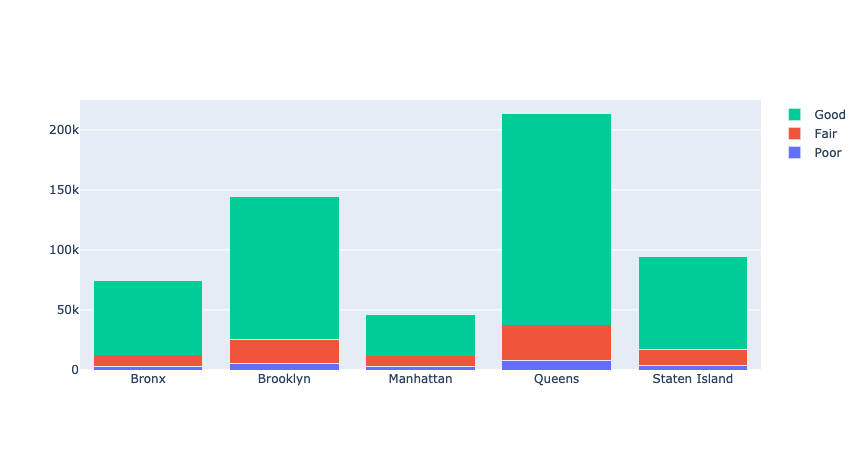

In [45]:
fig = go.Figure(
    data=[
        go.Bar(name='Poor',
               x=boro_health['boroname'].loc[boro_health['health']=='Poor'], 
               y=boro_health['count'].loc[boro_health['health']=='Poor']),
        go.Bar(name='Fair',
               x=boro_health['boroname'].loc[boro_health['health']=='Fair'], 
               y=boro_health['count'].loc[boro_health['health']=='Fair']),
        go.Bar(name='Good',
               x=boro_health['boroname'].loc[boro_health['health']=='Good'], 
               y=boro_health['count'].loc[boro_health['health']=='Good'])
])

fig.update_layout(barmode='stack')

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

<br>
<br>

We can improve our code above slightly by using list comprehension. Rather than manually specifying a dataframe for each of the 3 health conditions, we can use list comprehension to do this for us automatically.

Further, we add custom colors for the bars, change the width, and background color.

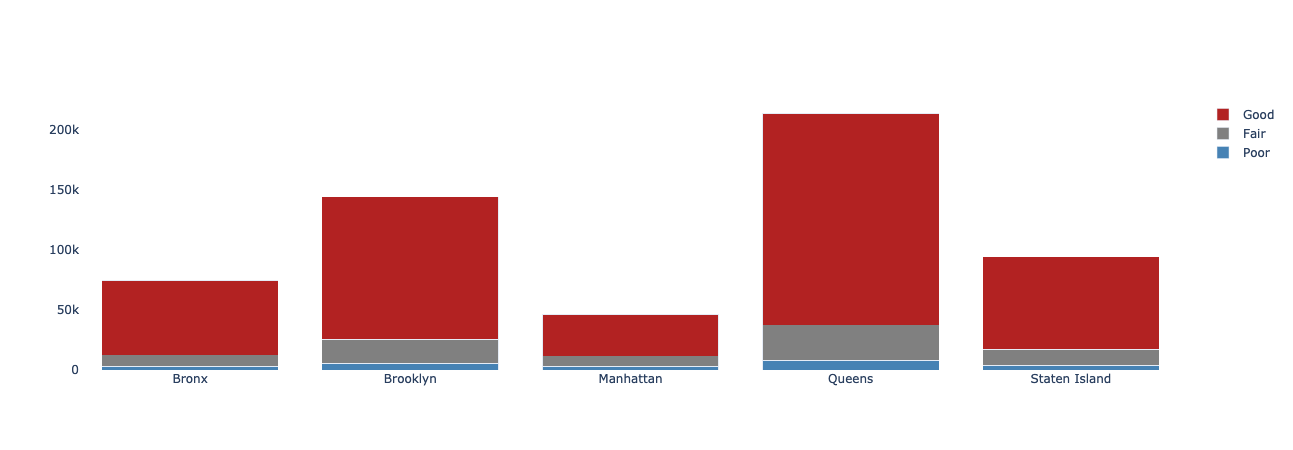

In [98]:
health_levels = ['Poor', 'Fair', 'Good']
colors = ['steelblue', 'grey', 'firebrick']

fig = go.Figure(
    data=[
        go.Bar(name=health,
               x=boro_health['boroname'].loc[boro_health['health']==health], 
               y=boro_health['count'].loc[boro_health['health']==health],
               marker_color=colors[idx]) for idx, health in enumerate(health_levels)
])

fig.update_layout(barmode='stack', 
                  plot_bgcolor='rgba(255,255,255,1)',
                  autosize=False,
                  width=500)

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

<br>
<br>

### Scatter Plots

For the final example we visualize 2 variables at the same time and at a more granular geographic unit, zip code. We use the groupby method once again to gather: how many trees are alive in each zipcode, and how many trees are in poor health condition.

In [78]:
trees.groupby(['boroname', 'zipcode'])['status'].value_counts()

boroname       zipcode  status
Bronx          10451    Alive      2189
                        Dead        109
                        Stump        71
               10452    Alive      2845
                        Dead        178
                                  ...  
Staten Island  10312    Stump       484
                        Dead        302
               10314    Alive     14643
                        Dead        295
                        Stump       201
Name: status, Length: 556, dtype: int64

In [82]:
zip_status = trees.groupby(['boroname', 'zipcode', 'status'])\
                  .agg({'status':'count'})\
                  .rename(columns={'status':'count'})\
                  .reset_index()
zip_health = trees.groupby(['boroname', 'zipcode', 'health'])\
                  .agg({'health':'count'})\
                  .rename(columns={'health':'h_count'})\
                  .reset_index()

In [85]:
data = pd.merge(zip_status, zip_health, on=['boroname', 'zipcode'])
data.head()

,boroname,zipcode,status,count,health,h_count
0,Bronx,10451,Alive,2189,Fair,439
1,Bronx,10451,Alive,2189,Good,1565
2,Bronx,10451,Alive,2189,Poor,185
3,Bronx,10451,Dead,109,Fair,439
4,Bronx,10451,Dead,109,Good,1565


In [86]:
data = data[(data['status']=='Alive') & (data['health']=='Poor')]
data.head()

,boroname,zipcode,status,count,health,h_count
2,Bronx,10451,Alive,2189,Poor,185
11,Bronx,10452,Alive,2845,Poor,165
20,Bronx,10453,Alive,2793,Poor,98
29,Bronx,10454,Alive,1352,Poor,46
38,Bronx,10455,Alive,1639,Poor,57


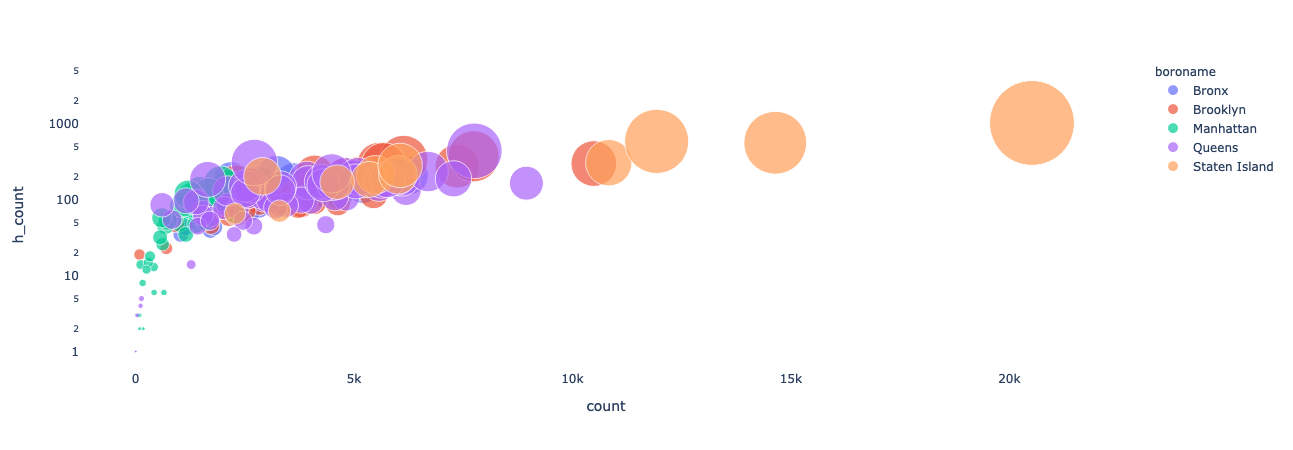

In [102]:
fig = px.scatter(data, x="count", y="h_count",
                 size="h_count", color="boroname",
                 hover_name="zipcode", log_y=True, size_max=60)
fig.update_layout(barmode='stack', 
                  plot_bgcolor='rgba(255,255,255,1)')
fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

### Exporting charts

Finally, Plotly has various methods for exporting charts as static images or interactive html files.

<br>

Exporting images can be done with the **write_image()** method – specifying the image type by adding the file extension at the end.

*note: ensure the Kaleido library is intsalled by running --> pip install -U kaleido*

In [104]:
fig.write_image("fig1.png")

<br>
<br>

Similarly, exporting html files can be done with the **write_html()** method.

In [105]:
fig.write_html("fig1.html")

End!